# A rectangle rotation puzzle

In [1]:
import math

import numpy as np
from media_tools import *
import cv2
import math
import matplotlib.pyplot as plt


Suppose you have a rectangle 2d array described by a `(h, w)` tuple.

In [2]:
rect = np.ones((100, 200))

Let's find the coordinates of the rectangle's points and return them as a list of tuples.

In [3]:
point_names = ['top_left', 'top_right', 'bottom_right', 'bottom_left']
rect_points = [(0, 0), (0, rect.shape[1] - 1), (rect.shape[0] - 1, rect.shape[1] - 1), (rect.shape[0] - 1, 0)]

# roll the points so that bottom_left is first
point_names = point_names[1:] + point_names[:1]
rect_points = rect_points[1:] + rect_points[:1]

# interweave the point names and points
print(np.array(list(zip(point_names, rect_points))))

[['top_right' (0, 199)]
 ['bottom_right' (99, 199)]
 ['bottom_left' (99, 0)]
 ['top_left' (0, 0)]]


## Rotating points by an angle around an origin:

Suppose you want to rotate the rectangle by $\theta$ degrees clockwise around an origin point. What would be the new coordinates of the rectangle's points?

In [4]:
theta = 45

# we need a function that takes a list of points and finds the middle point.
def find_middle(points):
    x_list = [x for (x, y) in points]
    y_list = [y for (x, y) in points]
    return [np.mean(x_list), np.mean(y_list)]

# we need a function that takes a list of points, a rotation angle, and an origin point and returns the coordinates of the rotated points on an array.
def rotate_points_around_origin(points, theta=0, origin=(0,0)):
    # if no origin is given, find the middle of the points
    if origin is "centre":
        origin = find_middle(points)
    # create a rotation matrix
    rot_mat = cv2.getRotationMatrix2D(origin, -theta, 1)
    # rotate the points and return the result as a list of tuples
    return [tuple(np.dot(rot_mat, (x, y, 1)).astype(int)) for (x, y) in points]

In [5]:
# let's print the original points for reference
print("Original points:\n", rect_points)

# let's get the rotated points for a rotation of 45 degrees at a few different origin points
new_points_45_around_center = rotate_points_around_origin(rect_points, theta, origin="centre")
new_points_45_around_bottom_left = rotate_points_around_origin(rect_points, theta, origin=rect_points[3])
new_points_45_around_bottom_right = rotate_points_around_origin(rect_points, theta, origin=rect_points[2])
new_points_45_around_top_right = rotate_points_around_origin(rect_points, theta, origin=rect_points[1])
new_points_45_around_top_left = rotate_points_around_origin(rect_points, theta, origin=rect_points[0])

# print the results
print("Rotated points, theta = {}, origin = {}:\n".format(theta, "centre"), new_points_45_around_center)
print("Rotated points, theta = {}, origin = {}:\n".format(theta, rect_points[0]), new_points_45_around_top_left)
print("Rotated points, theta = {}, origin = {}:\n".format(theta, rect_points[1]), new_points_45_around_top_right)
print("Rotated points, theta = {}, origin = {}:\n".format(theta, rect_points[2]), new_points_45_around_bottom_right)
print("Rotated points, theta = {}, origin = {}:\n".format(theta, rect_points[3]), new_points_45_around_bottom_left)

Original points:
 [(0, 199), (99, 199), (99, 0), (0, 0)]
Rotated points, theta = 45, origin = centre:
 [(-55, 134), (14, 204), (154, 64), (84, -5)]
Rotated points, theta = 45, origin = (0, 199):
 [(0, 199), (70, 269), (210, 128), (140, 58)]
Rotated points, theta = 45, origin = (99, 199):
 [(28, 128), (99, 198), (239, 58), (169, -11)]
Rotated points, theta = 45, origin = (99, 0):
 [(-111, 70), (-41, 140), (99, 0), (28, -70)]
Rotated points, theta = 45, origin = (0, 0):
 [(-140, 140), (-70, 210), (70, 70), (0, 0)]


## Drawing polygons from points:

Additionally, if we are going to draw the shapes, rotated, we need some functions to draw polygons.

In [291]:
# draw a polygon centered at an origin using cv2.fillPoly
def draw_poly(points, colour=(255, 255, 255, 255)):
    origin = np.floor(np.asarray(find_middle(points))).astype(int)
    # create an empty array to hold the polygon
    dim = (max([y for (x, y) in points]) - min([y for (x, y) in points]) + 1, max([x for (x, y) in points]) - min([x for (x, y) in points]) + 1, 4)
    # add the origin to the points
    points = [(x + origin[0], y + origin[1]) for (x, y) in points]
    # shift all points by the absolute of the minimum x and y values
    points = points + np.asarray([-min([x for (x, y) in points]), -min([y for (x, y) in points])])
    # create the container array
    poly_array = np.zeros(dim)
    poly_array[:, :, 3] = 255
    # fill the polygon
    cv2.fillPoly(poly_array, [np.asarray(points)], colour)
    return poly_array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


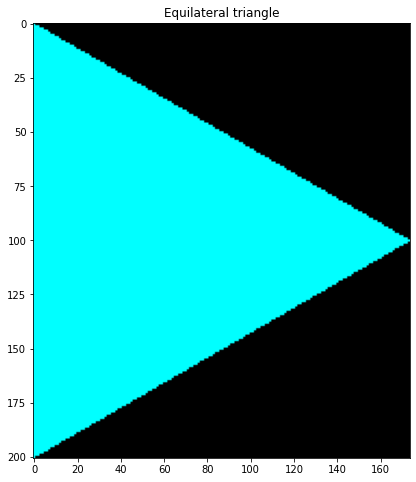

In [289]:
# given two points on an equilateral triangle, find the coordinates of the last point
equilateral_triangle_points = ((0, 0), (0, 200), tuple(np.floor(np.asarray((np.sqrt(200**2 - (200/2)**2), 200/2))).astype(int)))

# draw the equilateral triangle
equilateral_triangle = draw_poly(equilateral_triangle_points, colour=(0, 255, 255, 255))
image_tools.show_image(equilateral_triangle, axis=True, title="Equilateral triangle")

## Drawing polygons with alpha channels:

In [326]:
# get the polygon image arrays
rot_45_poly_around_centre = draw_poly(new_points_45_around_center, colour=(0, 255, 255, 255))
rot_45_poly_around_bottom_left = draw_poly(new_points_45_around_bottom_left, colour=(0, 255, 255, 255))
rot_45_poly_around_bottom_right = draw_poly(new_points_45_around_bottom_right, colour=(0, 255, 255, 255))
rot_45_poly_around_top_right = draw_poly(new_points_45_around_top_right, colour=(0, 255, 255, 255))
rot_45_poly_around_top_left = draw_poly(new_points_45_around_top_left, colour=(0, 255, 255, 255))

# plot the polygons separately
# image_tools.show_image(rot_45_poly_around_centre, axis=True, title="Polygon rotated 45 degrees around centre", scale_ratio=1)
# image_tools.show_image(rot_45_poly_around_bottom_left, axis=True, title="Polygon rotated 45 degrees around bottom left", scale_ratio=1)
# image_tools.show_image(rot_45_poly_around_bottom_right, axis=True, title="Polygon rotated 45 degrees around bottom right", scale_ratio=1)
# image_tools.show_image(rot_45_poly_around_top_right, axis=True, title="Polygon rotated 45 degrees around top right", scale_ratio=1)
# image_tools.show_image(rot_45_poly_around_top_left, axis=True, title="Polygon rotated 45 degrees around top left", scale_ratio=1)

Canvas shape: 
(300, 300, 4)
Rectangle shape: 
(100, 200)
Rectangle points: 
[(0, 199), (99, 199), (99, 0), (0, 0)]


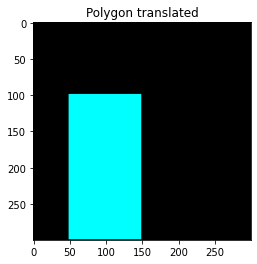

In [340]:
# create a blank canvas
canvas = np.zeros((300, 300, 4), np.uint8)
canvas[:, :, 3] = 255
print("Canvas shape: \n{}" .format(canvas.shape))

# rectangle
print("Rectangle shape: \n{}".format(rect.shape))
print("Rectangle points: \n{}".format(rect_points))
# get the rectangle as a filled polygon
poly = draw_poly(rect_points, colour=(0, 255, 255, 255))

# blit the the polygon onto the canvas, translated at the correct position

def blit_poly(poly, canvas, x, y):
    canvas[y:y+poly.shape[0], x:x+poly.shape[1]] = poly
    return canvas

# blit the polygons, translated at the correct position

displace = find_middle(rect_points)
# translate the polygons by displace
poly_translated = blit_poly(poly, canvas, int(displace[0]), int(displace[1]))


# show the canvas
image_tools.show_image(poly_translated, axis=True, title="Polygon translated", scale_ratio=1)





He's just so enthusiastic to label me a shitty person, to assume I'm just cruel.
He's a stubborn prick sometimes.